# Лабораторная работа №1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

np.random.seed(1)

## Обработка данных

In [2]:
data = pd.read_csv('pulsar_data_train.csv')

In [3]:
data = data.rename(columns={" Mean of the integrated profile": "Mean IP",
                            " Standard deviation of the integrated profile": "Std IP",
                            " Excess kurtosis of the integrated profile": "Kurtosis IP",
                            " Skewness of the integrated profile": "Skewness IP",
                            " Mean of the DM-SNR curve": "Mean DM-SNR",
                            " Standard deviation of the DM-SNR curve": "Std DM-SNR",
                            " Excess kurtosis of the DM-SNR curve": "Kurtosis DM-SNR",
                            " Skewness of the DM-SNR curve": "Skewness DM-SNR",
                            "target_class": "class"})
data['class'] = data['class'].astype('int32')

In [4]:
pulsar_means = dict()
non_pulsar_means = dict()
for column in ['Kurtosis IP', 'Std DM-SNR', 'Skewness DM-SNR']:
    pulsar_means[column] = data[data['class'] == 1][column].mean()
    non_pulsar_means[column] = data[data['class'] == 0][column].mean()
    
data[data['class'] == 1] = data[data['class'] == 1].fillna(pulsar_means)
data[data['class'] == 0] = data[data['class'] == 0].fillna(non_pulsar_means)

In [5]:
sample = data[data['class'] == 1]
while data[data['class'] == 1].shape[0] + sample.shape[0] < data[data['class'] == 0].shape[0]:
    data = pd.concat([data, sample])
data = pd.concat([data, sample.iloc[:data[data['class'] == 0].shape[0] - data[data['class'] == 1].shape[0]]])

In [6]:
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

In [7]:
x = data.drop(columns = 'class').to_numpy()
y = data['class'].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(x, y, train_size=0.8, random_state=1)

In [8]:
def scores(model, data, labels):
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## KNN

In [9]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, x in enumerate(data):
            neighbors = np.argpartition(((self.data - data[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.labels[neighbors], return_counts=True)
            res[i] = values[counts.argmax()]
        return res

In [10]:
gcv1 = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNN())]),
                    {'knn__k': [1, 5, 11, 15]})
gcv1.fit(train_data, train_labels)
print(gcv1.best_params_, gcv1.best_score_, sep='\n')

{'knn__k': 1}
0.991043956043956


Accuracy: 0.9923076923076923
Precision: 0.9847627340008707
Recall: 1.0


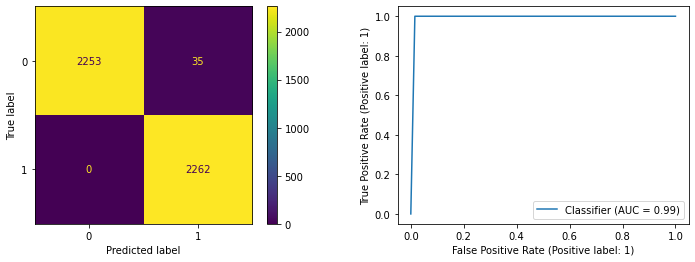

In [11]:
knn = gcv1.best_estimator_
scores(knn, test_data, test_labels)

In [12]:
with open('knn.pkl', 'wb') as f:
    pickle.dump(knn, f, pickle.HIGHEST_PROTOCOL)

Готовый классификатор

In [13]:
gcv2 = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
                    {'knn__n_neighbors': [1, 5, 11, 15]})
gcv2.fit(train_data, train_labels)
print(gcv2.best_params_, gcv2.best_score_, sep='\n')

{'knn__n_neighbors': 1}
0.991043956043956


Accuracy: 0.9923076923076923
Precision: 0.9847627340008707
Recall: 1.0


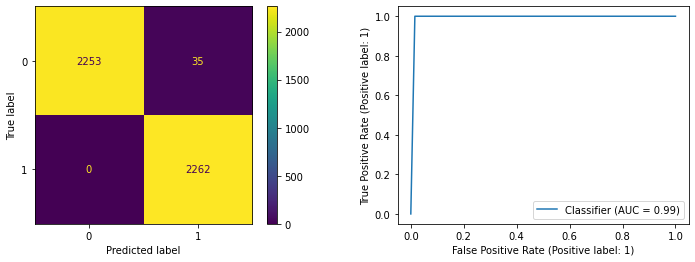

In [14]:
sk_knn = gcv2.best_estimator_
scores(sk_knn, test_data, test_labels)

## Naive Bayes

Версия с оценкой распределений

In [15]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.kde = []
        for c, count in zip(*np.unique(labels, return_counts=True)):
            self.kde.append([])
            for i in range(data.shape[1]):
                self.kde[-1].append(gaussian_kde(data[labels == c, i]))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, obj in enumerate(data):
            prob = np.array(self.classes)
            for j in range(len(self.classes)):
                for k, kde in enumerate(self.kde[j]):
                    prob[j] *= kde(obj[k])[0]
            res[i] = prob.argmax()
        return res

Accuracy: 0.9345054945054945
Precision: 0.9593077642656689
Recall: 0.9067197170645447


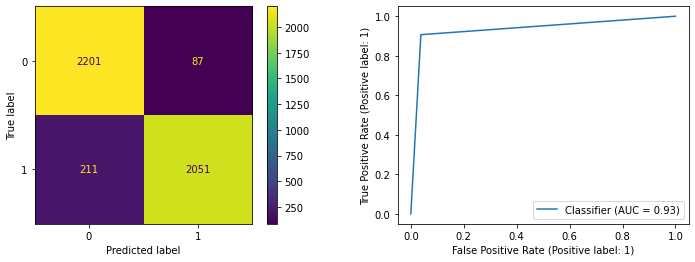

In [16]:
nb = Pipeline([('bayes', NaiveBayes())])
nb.fit(train_data, train_labels)
scores(nb, test_data, test_labels)

In [17]:
with open('naive_bayes.pkl', 'wb') as f:
    pickle.dump(nb, f, pickle.HIGHEST_PROTOCOL)

Версия с нормальным распределением

In [18]:
class GaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.means = []
        self.stds = []
        for c in np.unique(labels):
            self.means.append(data[labels == c,].mean(axis=0))
            self.stds.append(data[labels == c,].std(axis=0))
        self.classes = np.unique(labels, return_counts=True)[1] / len(labels)
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, obj in enumerate(data):
            prob = np.array(self.classes)
            for j in range(len(self.classes)):
                prob[j] *= np.cumprod(1 / self.stds[j] / np.sqrt(2 * np.pi) * np.exp(((obj - self.means[j]) / self.stds[j]) ** 2 / -2))[-1]
            res[i] = prob.argmax()
        return res

Accuracy: 0.9125274725274726
Precision: 0.9375586854460094
Recall: 0.8828470380194519


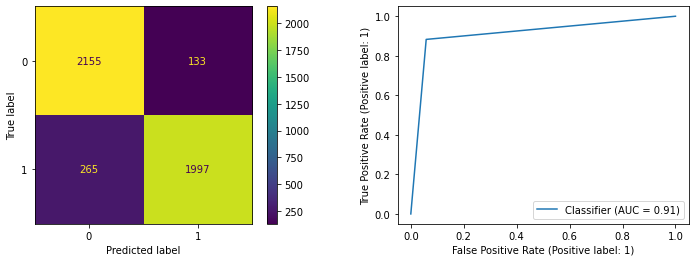

In [19]:
gnb = Pipeline([('gauss bayes', GaussianNaiveBayes())])
gnb.fit(train_data, train_labels)
scores(gnb, test_data, test_labels)

Готовый классификатор

Accuracy: 0.9125274725274726
Precision: 0.9375586854460094
Recall: 0.8828470380194519


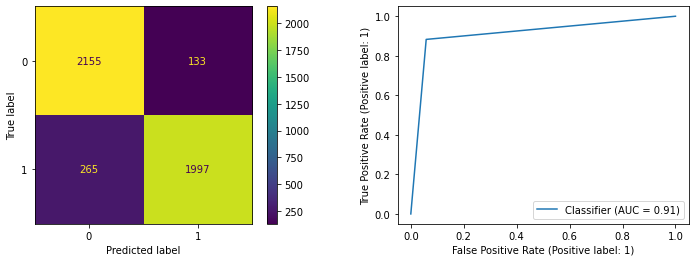

In [20]:
sk_gnb = GaussianNB()
sk_gnb.fit(train_data, train_labels)
scores(sk_gnb, test_data, test_labels)

Сравнение распределений признаков для ядерной оценки плотности и нормального распределения

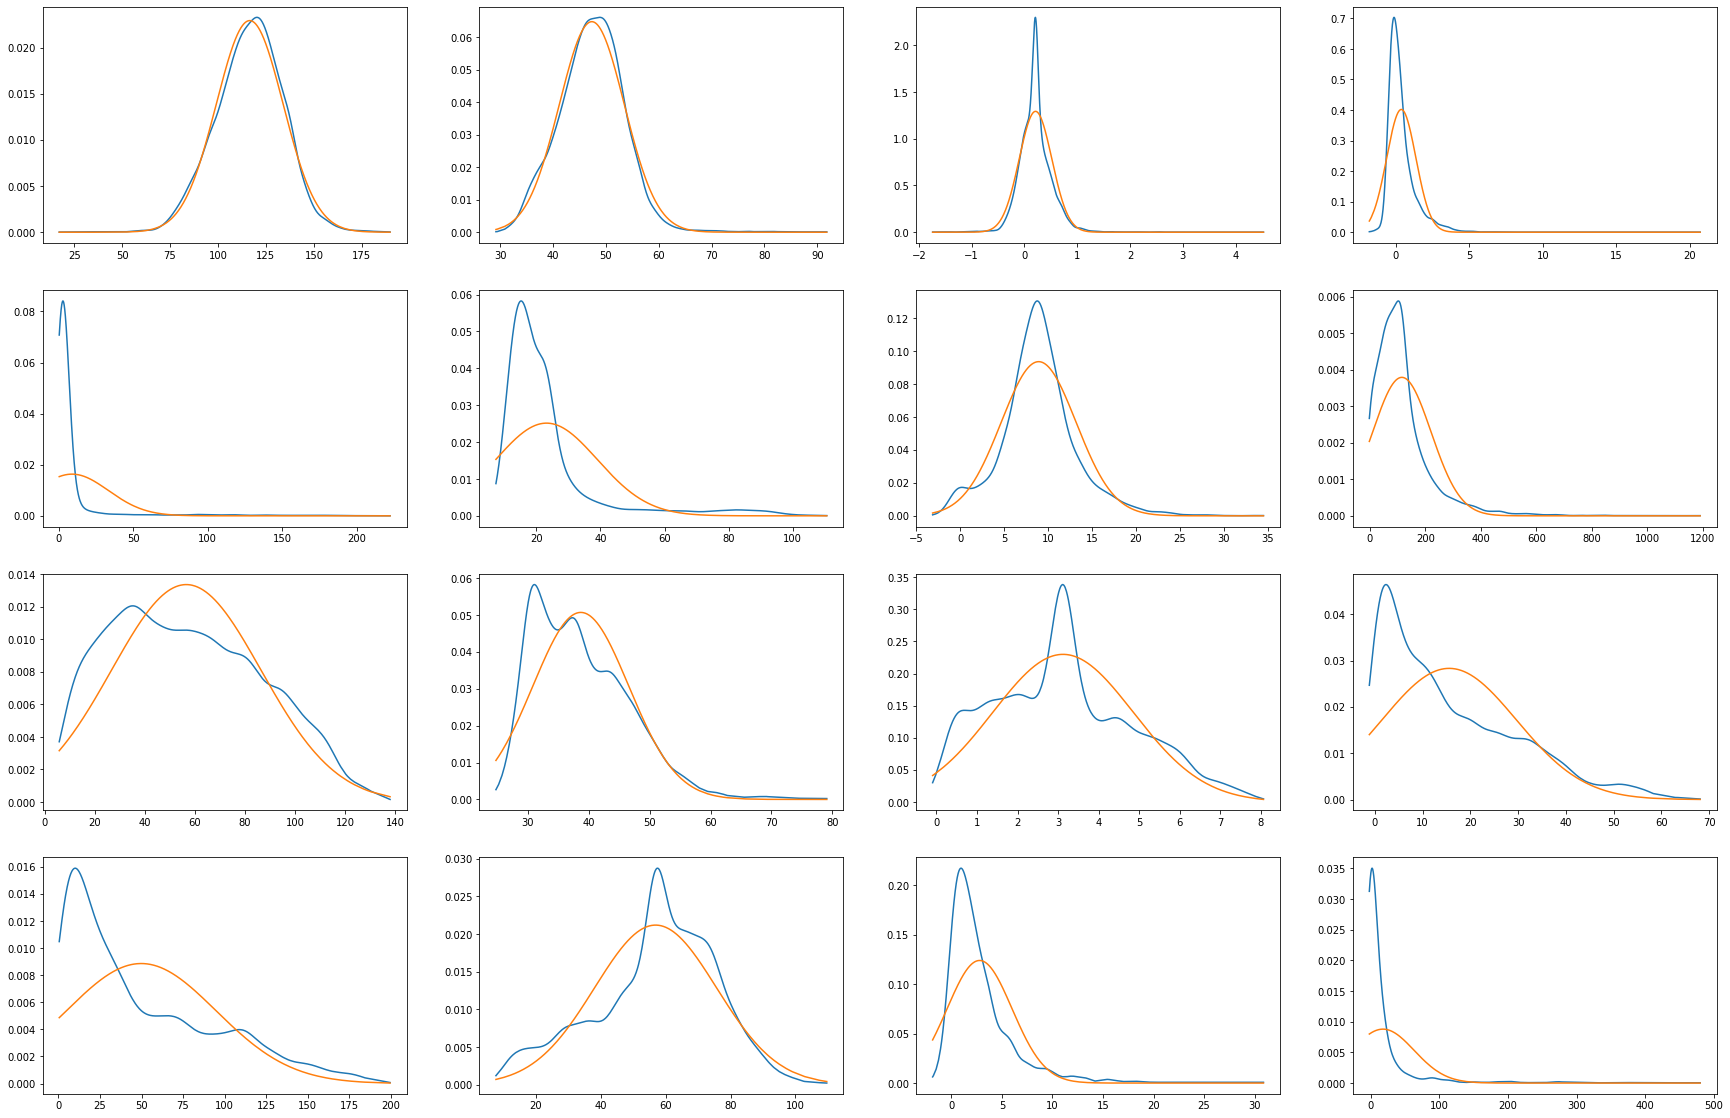

In [21]:
figure = plt.figure(figsize=(30, 20))
k = 1
for i in range(2):
    for j in range(8):
        feature = np.sort(train_data[train_labels == i, j])
        plt.subplot(4, 4, k)
        plt.plot(feature, nb['bayes'].kde[i][j](feature))
        plt.plot(feature, 1 / gnb['gauss bayes'].stds[i][j] / np.sqrt(2 * np.pi) * np.exp(((feature - gnb['gauss bayes'].means[i][j]) / gnb['gauss bayes'].stds[i][j]) ** 2 / -2))
        k += 1
plt.show()

## LogisticRegression

In [22]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')

In [23]:
rcv1 = RandomizedSearchCV(Pipeline([('normalizer', Normalizer()), ('log', LogisticRegression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
rcv1.fit(train_data, train_labels)
print(rcv1.best_params_, rcv1.best_score_, sep='\n')

{'log__lr': 0.1, 'log__epochs': 100, 'log__batch': 100, 'log__alpha': 0.0001}
0.9339010989010988


In [24]:
gcv3 = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', LogisticRegression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
gcv3.fit(train_data, train_labels)
print(gcv3.best_params_, gcv3.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__batch': 100, 'log__epochs': 100, 'log__lr': 0.1}
0.9337912087912088


Accuracy: 0.9345054945054945
Precision: 0.9716618635926993
Recall: 0.8943412908930151


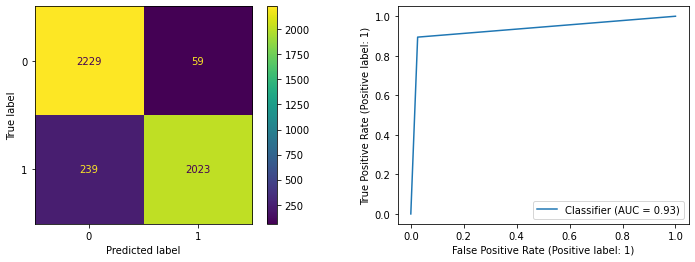

In [25]:
log = gcv3.best_estimator_
scores(log, test_data, test_labels)

In [26]:
with open('log_regr.pkl', 'wb') as f:
    pickle.dump(log, f, pickle.HIGHEST_PROTOCOL)

Готовый классификатор

In [27]:
gcv4 = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', SGDClassifier(loss='log', learning_rate='constant'))]),
                    {'log__eta0': [0.1, 0.01, 0.001], 'log__max_iter': [100, 1000, 5000], 
                     'log__alpha': [0.01, 0.001, 0.0001]})
gcv4.fit(train_data, train_labels)
print(gcv4.best_params_, gcv4.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__eta0': 0.1, 'log__max_iter': 1000}
0.9187912087912087


Accuracy: 0.9195604395604395
Precision: 0.9669950738916256
Recall: 0.867816091954023


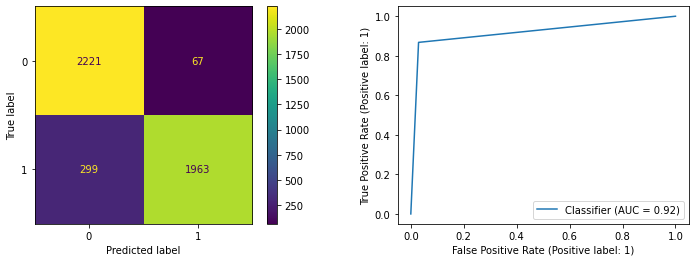

In [28]:
sk_log = gcv4.best_estimator_
scores(sk_log, test_data, test_labels)

## SVM

In [29]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2

In [30]:
rcv2 = RandomizedSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
rcv2.fit(train_data, train_labels)
print(rcv2.best_params_, rcv2.best_score_, sep='\n')

{'svm__lr': 0.01, 'svm__epochs': 10, 'svm__batch': 100, 'svm__alpha': 0.0001}
0.9510439560439561


In [31]:
gcv5 = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
gcv5.fit(train_data, train_labels)
print(gcv5.best_params_, gcv5.best_score_, sep='\n')

{'svm__alpha': 0.001, 'svm__batch': 100, 'svm__epochs': 100, 'svm__lr': 0.01}
0.9522527472527473


Accuracy: 0.9547252747252747
Precision: 0.978584729981378
Recall: 0.9292661361626879


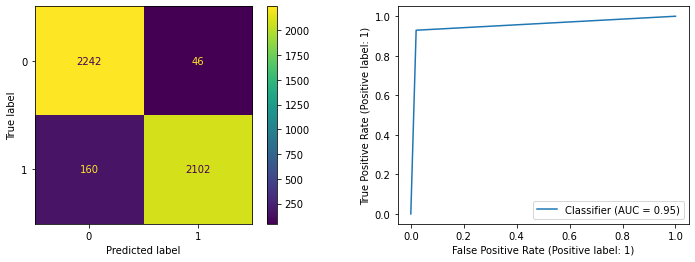

In [32]:
svm = gcv5.best_estimator_
scores(svm, test_data, test_labels)

In [33]:
with open('svm.pkl', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

Готовый классификатор

In [34]:
gcv6 = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('svm', SGDClassifier(loss='hinge', learning_rate='constant'))]),
                    {'svm__eta0': [0.1, 0.01, 0.001], 'svm__max_iter': [100, 1000, 5000], 
                     'svm__alpha': [0.01, 0.001, 0.0001]})
gcv6.fit(train_data, train_labels)
print(gcv6.best_params_, gcv6.best_score_, sep='\n')

{'svm__alpha': 0.0001, 'svm__eta0': 0.1, 'svm__max_iter': 1000}
0.9242857142857144


Accuracy: 0.9254945054945055
Precision: 0.9687957094100439
Recall: 0.8784261715296198


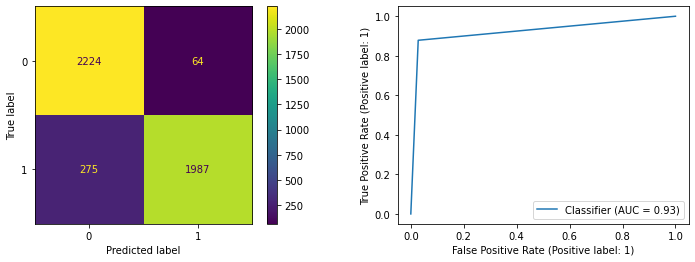

In [35]:
sk_svm = gcv6.best_estimator_
scores(sk_svm, test_data, test_labels)